In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=8)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR-10 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the GradScaler for mixed precision training
scaler = GradScaler()

# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        # print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}')

# Save model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Train baseline model
train_model(model, train_loader, criterion, optimizer)

# Save the baseline model
save_model(model, './cif_baseline_model.pth')

# Evaluation function
def evaluate_model(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate baseline model
accuracy = evaluate_model(model, test_loader, criterion)
print(f'Baseline Model Accuracy: {accuracy}%')

# Active Learning Setup
initial_indices = np.random.choice(len(train_dataset), 5000, replace=False)
current_indices = initial_indices.tolist()
remaining_indices = list(set(range(len(train_dataset))) - set(current_indices))

for loop in range(10):  # Example loop, adjust as needed
    print(f"Active Learning Loop {loop+1}")
    subset_train_loader = DataLoader(Subset(train_dataset, current_indices), batch_size=128, shuffle=True, num_workers=8)
    train_model(model, subset_train_loader, criterion, optimizer, epochs=20)

    # # Save the model after each active learning loop
    # save_model(model, f'./cif_active_learning_model_loop_{loop+1}.pth')

    # Select new samples based on uncertainty (simplified)
    model.eval()
    uncertainties = []
    with torch.no_grad():
        for inputs, _ in DataLoader(Subset(train_dataset, remaining_indices), batch_size=128, shuffle=False, num_workers=8):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            uncertainty = 1 - probs.max(dim=1)[0]
            uncertainties.extend(uncertainty.cpu().numpy())

    uncertainties = np.array(uncertainties)
    query_indices = np.argsort(uncertainties)[-5000:].tolist()  # Select top 5000 uncertain samples
    new_indices = [remaining_indices[i] for i in query_indices]
    current_indices.extend(new_indices)
    remaining_indices = list(set(remaining_indices) - set(new_indices))

# Final evaluation after active learning
accuracy = evaluate_model(model, test_loader, criterion)
print(f'Active Learning Model Accuracy: {accuracy}%')

# Save the final active learning model
save_model(model, './cif_active_learning_model_final.pth')


Files already downloaded and verified
Files already downloaded and verified
Active Learning Loop 1
Active Learning Loop 2
Active Learning Loop 3
Active Learning Loop 4
Active Learning Loop 5
Active Learning Loop 6
Active Learning Loop 7
Active Learning Loop 8
Active Learning Loop 9
Active Learning Loop 10
Active Learning Model Accuracy: 80.22%
Model saved to ./cif_active_learning_model_final.pth


In [ ]:
from google.colab import files
files.download('cif_active_learning_model_final.pth')
files.download('cif_baseline_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Extracted features shape: (10000, 512, 1, 1)


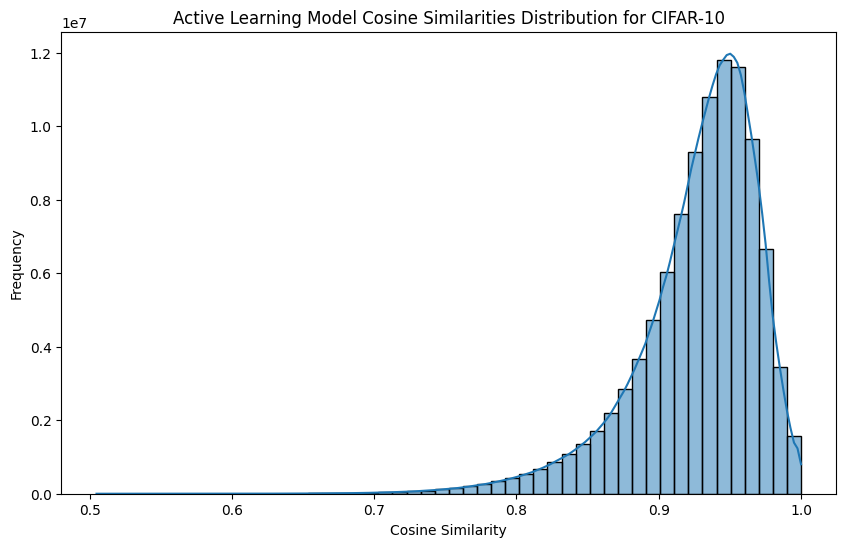

In [ ]:
# Define a function to modify the model to extract features from a specific layer
def get_feature_extractor(model, layer_name):
    feature_extractor = nn.Sequential()
    for name, module in model.named_children():
        feature_extractor.add_module(name, module)
        if name == layer_name.split('.')[0]:
            break

    layer_parts = layer_name.split('.')[1:]
    for part in layer_parts:
        feature_extractor.add_module(part, getattr(feature_extractor[-1], part))

    return feature_extractor

# Define a function to extract features
def extract_features(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())

    features = np.concatenate(features)
    print(f"Extracted features shape: {features.shape}")
    return features

def load_model(weights_path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR-10 classes
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

#baseline_model = load_model('cif_baseline_model.pth')
alub_model = load_model('cif_active_learning_model_final.pth')

# Extract features
layer_name = 'layer4.1.conv2'
baseline_features = extract_features(baseline_model, test_loader, layer_name)
alub_features = extract_features(alub_model, test_loader, layer_name)

# Calculate cosine similarity for baseline
baseline_features = baseline_features.reshape(baseline_features.shape[0], -1)
alub_features = alub_features.reshape(alub_features.shape[0], -1)

#cos_sim_baseline = cosine_similarity(baseline_features)
cos_sim_alub = cosine_similarity(alub_features)

# Plot cosine similarity for baseline model
plt.figure(figsize=(10, 6))
sns.histplot(cos_sim_baseline.flatten(), bins=50, kde=True)
plt.title('Baseline Model Cosine Similarities Distribution for CIFAR-10')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

# Plot cosine similarity for active learning model
plt.figure(figsize=(10, 6))
sns.histplot(cos_sim_alub.flatten(), bins=50, kde=True)
plt.title('Active Learning Model Cosine Similarities Distribution for CIFAR-10')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def compute_cosine_similarity(features):
    features_flat = features.reshape(features.shape[0], -1)  # Flatten feature vectors
    cos_sim = cosine_similarity(features_flat)
    return cos_sim

baseline_cos_sim = compute_cosine_similarity(baseline_features)
alub_cos_sim = compute_cosine_similarity(alub_features)

# Function to plot cosine similarity heatmaps
def plot_cosine_similarity_heatmap(cos_sim, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim, cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel('Feature Vector Index')
    plt.ylabel('Feature Vector Index')
    plt.show()

# Plot heatmaps
plot_cosine_similarity_heatmap(baseline_cos_sim, 'Cifar Baseline Model Cosine Similarities Heatmap')
plot_cosine_similarity_heatmap(alub_cos_sim, 'Cifar Active Learning Model Cosine Similarities Heatmap')

In [ ]:
print("Baseline features statistics:")
print(f"Mean: {baseline_features.mean()}, Std: {baseline_features.std()}")

print("Active Learning features statistics:")
print(f"Mean: {alub_features.mean()}, Std: {alub_features.std()}")

In [ ]:
def compute_cosine_similarity_statistics(cos_sim):
    mean = np.mean(cos_sim)
    std = np.std(cos_sim)
    min_val = np.min(cos_sim)
    max_val = np.max(cos_sim)
    quantiles = np.percentile(cos_sim, [25, 50, 75])

    return {
        "mean": mean,
        "std": std,
        "min": min_val,
        "max": max_val,
        "25th_percentile": quantiles[0],
        "50th_percentile": quantiles[1],
        "75th_percentile": quantiles[2]
    }

baseline_stats = compute_cosine_similarity_statistics(baseline_cos_sim)
alub_stats = compute_cosine_similarity_statistics(alub_cos_sim)

print("Baseline Model Cosine Similarity Statistics:", baseline_stats)
print("Active Learning Model Cosine Similarity Statistics:", alub_stats)


Baseline Model Cosine Similarity Statistics: {'mean': 0.8904636, 'std': 0.06959827, 'min': 0.4579363, 'max': 1.0000007, '25th_percentile': 0.8536458015441895, '50th_percentile': 0.9047056436538696, '75th_percentile': 0.9419647455215454}
Active Learning Model Cosine Similarity Statistics: {'mean': 0.9719364, 'std': 0.019097274, 'min': 0.8340925, 'max': 1.0000007, '25th_percentile': 0.9632309675216675, '50th_percentile': 0.9775481224060059, '75th_percentile': 0.985525369644165}


100%|██████████| 170498071/170498071 [00:02<00:00, 80118786.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


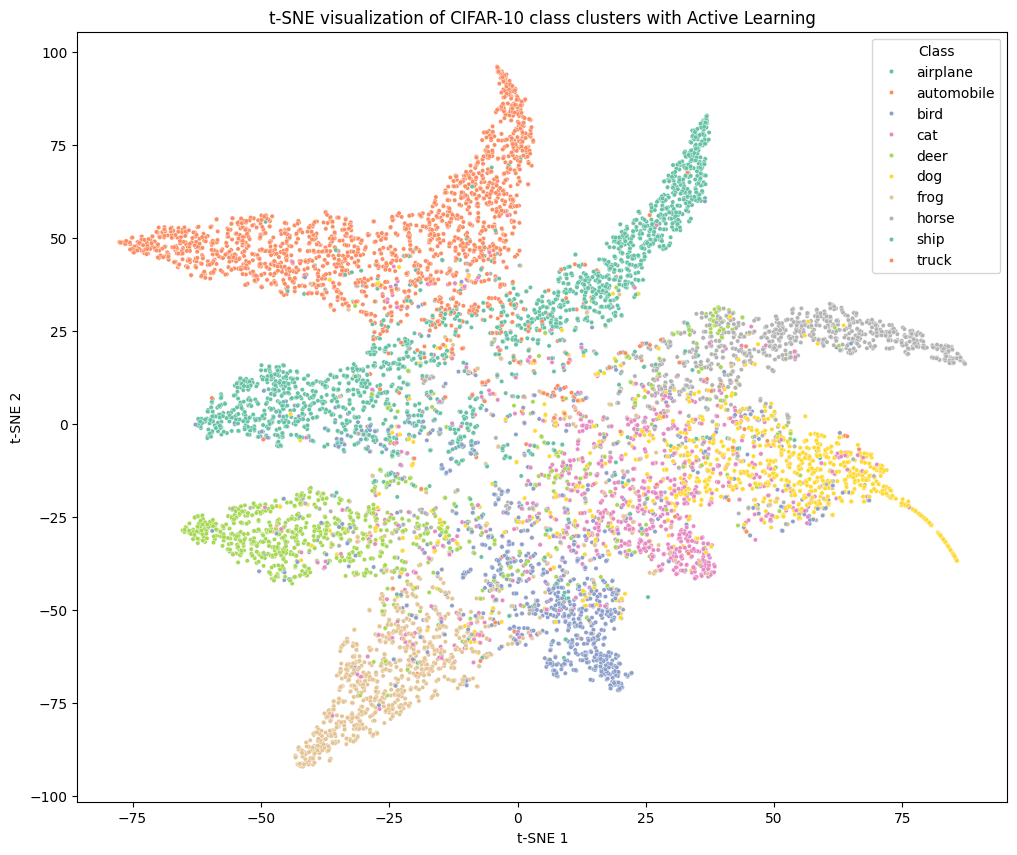

Active Learning Model - Silhouette Score: 0.13047167658805847, Davies-Bouldin Index: 1.8460682788609746


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define a function to get the feature extractor up to a specific layer
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = torch.nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

# Define a function to extract features and check labels during the process
def extract_features_with_label_check(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())
            #print("Batch labels:", label)  # Print labels for each batch

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Load the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR-10 classes
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

# Load the model and set to evaluation mode
model = load_model('cif_active_learning_model_final.pth')
model.eval()

# Extract features and labels from the specified layer
layer_name = 'layer4'
features, labels = extract_features_with_label_check(model, test_loader, layer_name)
features = features.reshape(features.shape[0], -1)  # Flatten feature vectors

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE embeddings with correct hue
class_names = test_dataset.classes  # Get class names
palette = sns.color_palette("Set2", len(np.unique(labels)))

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=palette, legend='full', s=10)

# Add legend with class names
handles, _ = scatter.get_legend_handles_labels()
scatter.legend(handles=handles, labels=class_names, loc='upper right', title='Class')

plt.title('t-SNE visualization of CIFAR-10 class clusters with Active Learning')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Calculate silhouette score and Davies-Bouldin index
silhouette_active = silhouette_score(tsne_features, labels)
db_active = davies_bouldin_score(tsne_features, labels)

print(f'Active Learning Model - Silhouette Score: {silhouette_active}, Davies-Bouldin Index: {db_active}')


Files already downloaded and verified


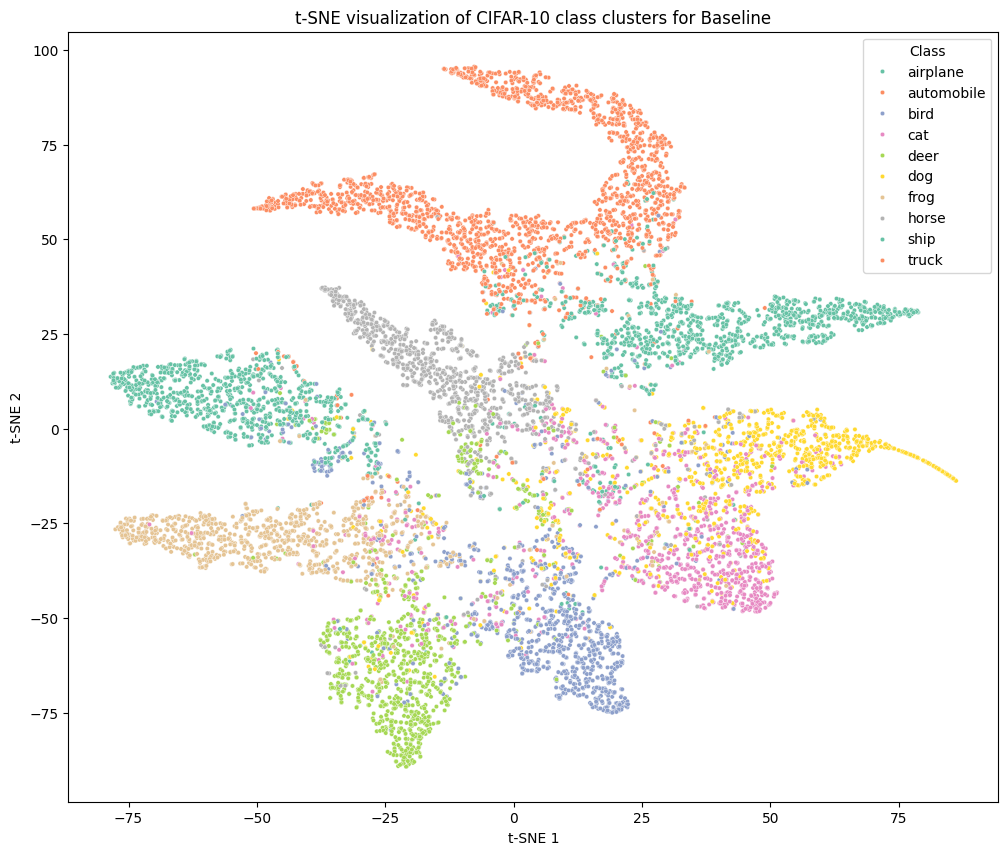

Baseline Model - Silhouette Score: 0.2117142528295517, Davies-Bouldin Index: 1.551130132272291


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define a function to get the feature extractor up to a specific layer
def get_feature_extractor(model, layer_name):
    layer = dict([*model.named_modules()])[layer_name]
    feature_extractor = torch.nn.Sequential(*list(model.children())[:list(model.children()).index(layer) + 1])
    return feature_extractor

# Define a function to extract features and check labels during the process
def extract_features_with_label_check(model, loader, layer_name):
    feature_extractor = get_feature_extractor(model, layer_name).to(device)
    feature_extractor.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in loader:
            inputs = inputs.to(device)
            outputs = feature_extractor(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(label.cpu().numpy())
            #print("Batch labels:", label)  # Print labels for each batch

    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# Load the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(weights_path):
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting for CIFAR-10 classes
    model.load_state_dict(torch.load(weights_path))
    model.to(device)
    return model

# Load the model and set to evaluation mode
model = load_model('cif_baseline_model.pth')
model.eval()

# Extract features and labels from the specified layer
layer_name = 'layer4'
features, labels = extract_features_with_label_check(model, test_loader, layer_name)
features = features.reshape(features.shape[0], -1)  # Flatten feature vectors

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot t-SNE embeddings with correct hue
class_names = test_dataset.classes  # Get class names
palette = sns.color_palette("Set2", len(np.unique(labels)))

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=palette, legend='full', s=10)

# Add legend with class names
handles, _ = scatter.get_legend_handles_labels()
scatter.legend(handles=handles, labels=class_names, loc='upper right', title='Class')

plt.title('t-SNE visualization of CIFAR-10 class clusters for Baseline')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Calculate silhouette score and Davies-Bouldin index
silhouette_active = silhouette_score(tsne_features, labels)
db_active = davies_bouldin_score(tsne_features, labels)

print(f'Baseline Model - Silhouette Score: {silhouette_active}, Davies-Bouldin Index: {db_active}')


For Neuron 8


100%|██████████| 512/512 [00:07<00:00, 65.71it/s]



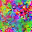

For Neuron 25


100%|██████████| 512/512 [00:07<00:00, 66.92it/s]



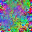

For Neuron 54


100%|██████████| 512/512 [00:07<00:00, 65.38it/s]



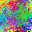

For Neuron 89


100%|██████████| 512/512 [00:07<00:00, 64.26it/s]



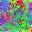

For Neuron 131


100%|██████████| 512/512 [00:07<00:00, 65.05it/s]



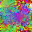

For Neuron 200


100%|██████████| 512/512 [00:07<00:00, 65.32it/s]



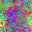

For Neuron 221


100%|██████████| 512/512 [00:07<00:00, 65.75it/s]



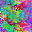

For Neuron 276


100%|██████████| 512/512 [00:07<00:00, 65.77it/s]



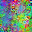

For Neuron 340


100%|██████████| 512/512 [00:07<00:00, 64.35it/s]



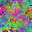

For Neuron 455


100%|██████████| 512/512 [00:07<00:00, 64.92it/s]



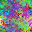

For Neuron 500


100%|██████████| 512/512 [00:08<00:00, 62.98it/s]



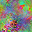

In [ ]:
num_classes = 10

# Define the model architecture
model = models.resnet18(num_classes)  # Adjust the number of classes as needed
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Load the pre-trained weights
model.load_state_dict(torch.load('cif_active_learning_model_final.pth'))

# Move the model to the appropriate device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

param_f_cif = lambda : lucent.optvis.param.image(32, channels=3)

def visualize_with_lucent(layer, channels):
    cif_dir = 'Cif/' + layer
    if not os.path.exists(cif_dir):
      os.makedirs(cif_dir)

    for i in (channels):
      print(f"For Neuron {i}")
      layer_name = layer + ':' + str(i)
      alub_image = render.render_vis(model, layer_name, param_f_cif, preprocess=False, show_inline=True)
      plt.imshow(alub_image[0][0, :, :, 0:3])
      plt.axis('off')  # To turn off the axis, making the image cleaner
      plt.savefig((cif_dir + '/' + str(i) + '.png'), bbox_inches='tight', pad_inches=0)
      plt.close()

neurons = [8, 25, 54, 89, 131, 200, 221, 276, 340, 455, 500]
visualize_with_lucent('layer4_1_conv2', neurons)

In [ ]:
!zip -r cif_alub_layer4_1_conv2.zip Cif/layer4_1_conv2/
from google.colab import files
files.download('cif_alub_layer4_1_conv2.zip')

  adding: Cif/layer4_1_conv2/ (stored 0%)
  adding: Cif/layer4_1_conv2/500.png (deflated 22%)
  adding: Cif/layer4_1_conv2/8.png (deflated 21%)
  adding: Cif/layer4_1_conv2/25.png (deflated 21%)
  adding: Cif/layer4_1_conv2/200.png (deflated 21%)
  adding: Cif/layer4_1_conv2/89.png (deflated 22%)
  adding: Cif/layer4_1_conv2/221.png (deflated 21%)
  adding: Cif/layer4_1_conv2/54.png (deflated 21%)
  adding: Cif/layer4_1_conv2/455.png (deflated 22%)
  adding: Cif/layer4_1_conv2/131.png (deflated 22%)
  adding: Cif/layer4_1_conv2/340.png (deflated 22%)
  adding: Cif/layer4_1_conv2/276.png (deflated 22%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>